<a href="https://colab.research.google.com/github/Raghava-Gatadi/cybersecurity/blob/master/RealorFake_political_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git
!pip install scikit-learn
!pip install tensorflow
!python -m spacy download en_core_web_lg
!pip install ktrain

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-smqx08qd
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-smqx08qd
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=76d2cf425bd889388399401ec37fb932d8583d1d78d44f5fc69ea4cf01b2bceb
  Stored in directory: /tmp/pip-ephem-wheel-cache-0hc38_9k/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you ma

In [ ]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
tweet = pd.read_csv('https://raw.githubusercontent.com/Raghava-Gatadi/Real_or_Fake_Political_Tweet/master/Truth_Seeker_Model_Dataset.csv')
tweet.head()
print(tweet.shape,"\n")
print(tweet.info())
results = {}

(134198, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       134198 non-null  int64  
 1   author                   134198 non-null  object 
 2   statement                134198 non-null  object 
 3   target                   134198 non-null  bool   
 4   BinaryNumTarget          134198 non-null  float64
 5   manual_keywords          134198 non-null  object 
 6   text                     134198 non-null  object 
 7   5_label_majority_answer  134198 non-null  object 
 8   3_label_majority_answer  134198 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 8.3+ MB
None


## Exploratory Data Analysis

<ipython-input-8-daf87454c0b4>:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(x='target', data=tweet, palette=light_palette, hue='target')


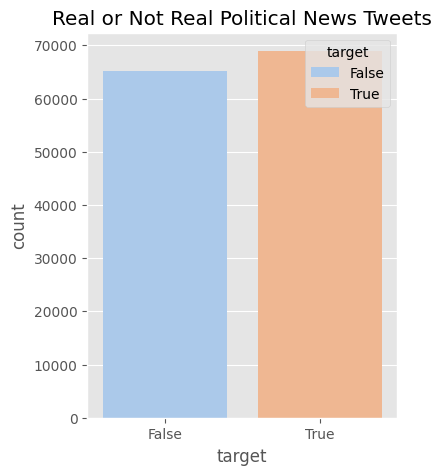

In [ ]:
light_palette = sns.color_palette("pastel")

plt.figure(figsize=(4, 5))
sns.countplot(x='target', data=tweet, palette=light_palette, hue='target')
plt.title('Real or Not Real Political News Tweets')

plt.show()

<Axes: ylabel='count'>

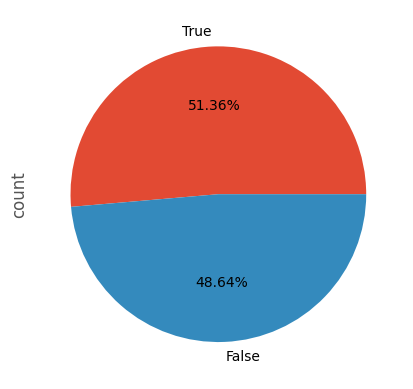

In [ ]:
tweet['target'].value_counts()
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

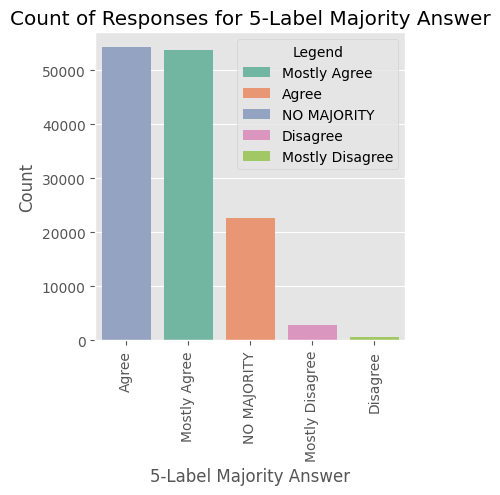

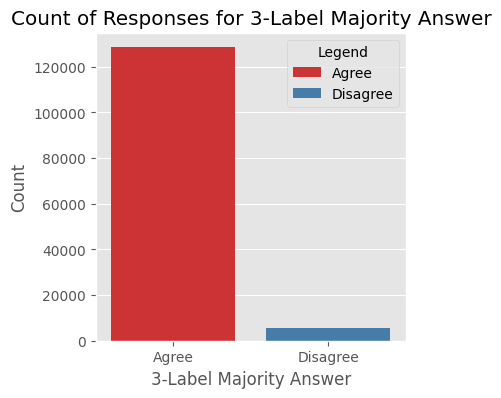

In [ ]:
plt.figure(figsize=(4, 4))  # Optional: Set the figure size
sns.countplot(x='5_label_majority_answer', data=tweet, palette='Set2', hue = '5_label_majority_answer',order=tweet['5_label_majority_answer'].value_counts().index)
plt.title('Count of Responses for 5-Label Majority Answer')
plt.xlabel('5-Label Majority Answer')
plt.xticks(rotation=90)
plt.ylabel('Count')

# Add a legend to the top-right corner
plt.legend(title='Legend', labels=['Mostly Agree', 'Agree', 'NO MAJORITY', 'Disagree', 'Mostly Disagree'], loc='upper right')

plt.show()
print()
# Count plot for '3_label_majority_answer'
plt.figure(figsize=(4, 4))  # Optional: Set the figure size
sns.countplot(x='3_label_majority_answer', data=tweet, palette='Set1', hue = '3_label_majority_answer',order=tweet['3_label_majority_answer'].value_counts().index)
plt.title('Count of Responses for 3-Label Majority Answer')
plt.xlabel('3-Label Majority Answer')
plt.ylabel('Count')

# Add a legend to the top-right corner
plt.legend(title='Legend', labels=['Agree', 'Disagree', 'NO MAJORITY'], loc='upper right')

plt.show()

## Number of Character Distribution in Tweets

In [ ]:
import preprocess_kgptalkie as kgp
kgp.get_basic_features(tweet)

,id,author,statement,target,BinaryNumTarget,manual_keywords,text,5_label_majority_answer,3_label_majority_answer,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\r\n\r\n...,Mostly Agree,Agree,247,40,6.175000,6,0,1,13,5
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree,257,44,5.840909,20,0,3,9,0
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree,187,35,5.342857,14,0,0,1,5
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\r\n\r\nBroken campaign p...,Mostly Agree,Agree,249,37,6.729730,4,0,1,13,3
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree,205,35,5.857143,10,0,1,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134193,134193,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0.0,"Biden, great grandfather, slave owner",Joe Biden's family owned African slaves....\r\...,Mostly Agree,Agree,149,25,5.960000,6,0,0,6,1
134194,134194,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0.0,"Biden, great grandfather, slave owner","Joe Bidens great, great grandfather was a slav...",Agree,Agree,69,14,4.928571,2,0,0,4,0
134195,134195,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0.0,"Biden, great grandfather, slave owner","@ChevyChaseToGo ""Joe Bidens great-grandfather ...",Mostly Agree,Agree,122,19,6.421053,6,0,1,3,1
134196,134196,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0.0,"Biden, great grandfather, slave owner",@JoeBiden Facts are Bidens VP Kamala Harris Gr...,NO MAJORITY,Agree,221,44,5.022727,12,0,1,2,3


<Axes: xlabel='char_counts', ylabel='Count'>

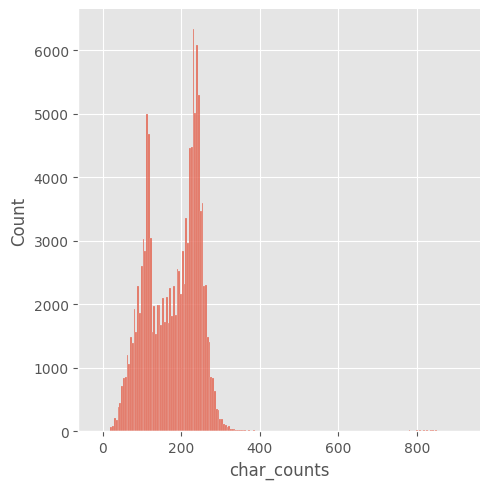

In [ ]:
sns.displot(tweet['char_counts'])
sns.kdeplot(tweet['char_counts'], fill=True)

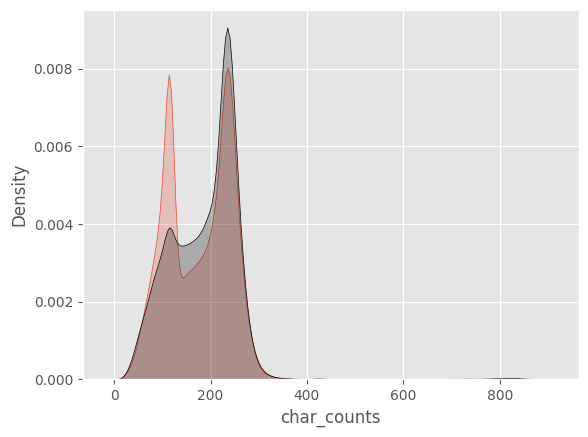

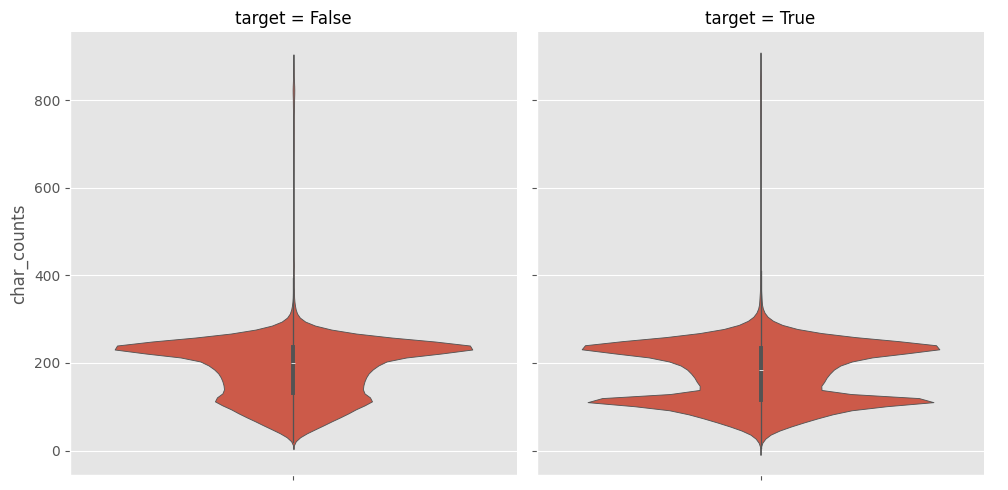

In [ ]:
sns.kdeplot(tweet[tweet['target']==True]['char_counts'], fill=True)
print()
sns.kdeplot(tweet[tweet['target']==False]['char_counts'], fill=True, color='Black')
print()
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

### Number of words, Average works length, and stop words Distribution in Tweets

<Axes: xlabel='word_counts', ylabel='Density'>

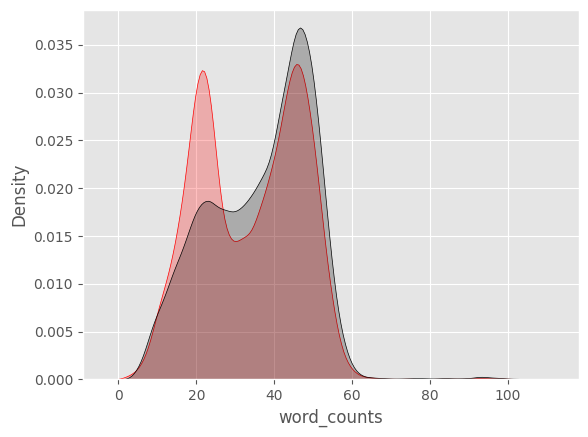

In [ ]:
sns.kdeplot(tweet[tweet['target']==True]['word_counts'], fill=True, color='Red')
sns.kdeplot(tweet[tweet['target']==False]['word_counts'], fill=True, color='Black')

<Axes: xlabel='avg_wordlength', ylabel='Density'>

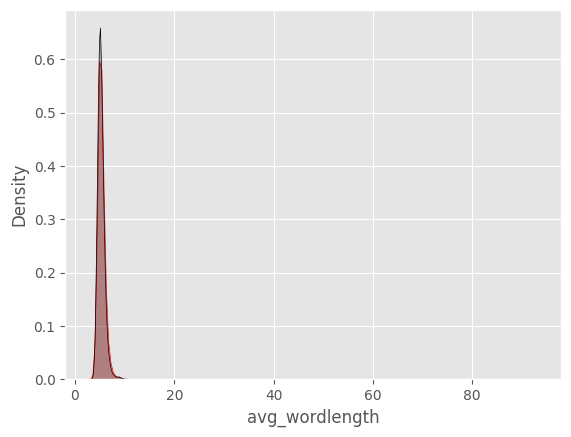

In [ ]:
sns.kdeplot(tweet[tweet['target']==True]['avg_wordlength'], fill=True, color='Red')
sns.kdeplot(tweet[tweet['target']==False]['avg_wordlength'], fill=True, color='Black')

<Axes: xlabel='stopwords_counts', ylabel='Density'>

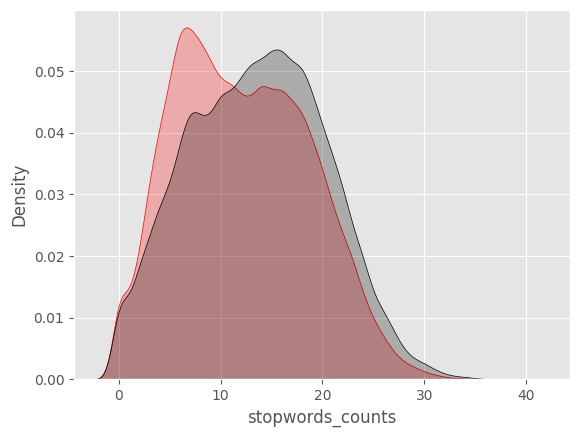

In [ ]:
sns.kdeplot(tweet[tweet['target']==True]['stopwords_counts'], fill=True, color='Red')
sns.kdeplot(tweet[tweet['target']==False]['stopwords_counts'], fill=True, color='Black')

### Most and Least common words

Unigram word frequency plots

In [ ]:
freqs = kgp.get_word_freqs(tweet, 'text')

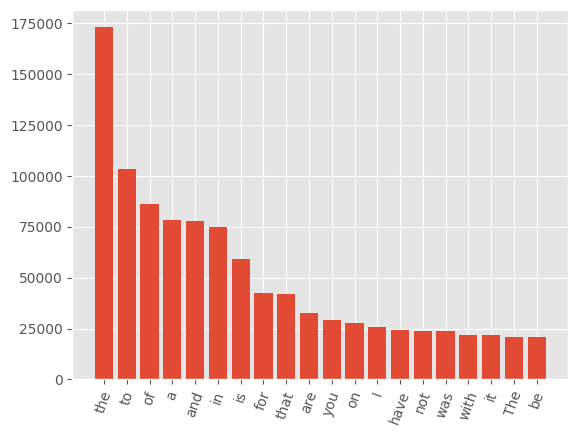

In [ ]:
top20 = freqs[:20]
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

Bigram word frequency plots

In [ ]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)


In [ ]:
bigram

[('zzzzzzzz biden', 1205558),
 ('zzzzzzz40870953 irish61j', 1205557),
 ('zzzz waiting', 1205556),
 ('zzzz cases', 1205555),
 ('zzzfa20dit jtwrski', 1205554),
 ('zzzfa20dit dadsbreak', 1205553),
 ('zzzbeeme juddlegum', 1205552),
 ('zzzbeeme briantylercohen', 1205551),
 ('zzz and', 1205550),
 ('zzyzx91 she', 1205549),
 ('zztop5252 forashli', 1205548),
 ('zzskaterkidzz nihilistunicorn', 1205547),
 ('zzirggobucks carolinatitan10', 1205546),
 ('zzimbo1 have', 1205545),
 ('zzcouch1gmailc3 oklahomapatrio1', 1205544),
 ('zzcouch1gmailc3 ldog562', 1205543),
 ('zzcastlezz stewheckenberg', 1205542),
 ('zythophiliac zetetic2017', 1205541),
 ('zyrofoxtrot whitehouse', 1205540),
 ('zyrofoxtrot dybarb', 1205539),
 ('zyrkon gas', 1205538),
 ('zyqas0xfl40tad gracierobert6', 1205537),
 ('zypisfy rani84279141', 1205536),
 ('zypisfy kim_because', 1205535),
 ('zypisfy geraldpayne25', 1205534),
 ('zypisfy galcondude', 1205533),
 ('zypisfy cern_lxxl', 1205532),
 ('zyphorr1 tariqnasheed', 1205531),
 ('zyphery

### One shot Data Cleaning

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', '  ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [ ]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))
tweet.head()['text']

/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


0    potus biden blunders 6 month updateinflation d...
1    s0sickrick stairmaster 6d6f636869 not as many ...
2    the supreme court is siding with super rich pr...
3    potus biden blundersbroken campaign promises i...
4    ohcomfy i agree the confluence of events right...
Name: text, dtype: object

# Disaster Words Visualization with Word Cloud

In [ ]:
real = kgp.get_word_freqs(tweet[tweet['target']==1],'text')
real = ' '.join(real.index)
real


'the to of in and a is that for you not are it i on have trump more with was has than he be from this they people as by but we do all so at about no who his will if or an us would years americans their out just were there what obama your new tax like when rate states one up wage only over our now jobs 1 how did its why since can had highest minimum get been realdonaldtrump my black because year time marijuana million state health last them same should 2 american against white money also other taxes know texas even s many most does country support said 4 which 10 pay right america think per after want any need federal president vote then being income still every make under never women act today 50 first those him border care percent less background much gun me some 5 3 while york united dont world am day paid checks bill take public before family going good way 6 7 20 african go times these could where into republicans say 2016 well donald work biden government down 40 inflation fact co

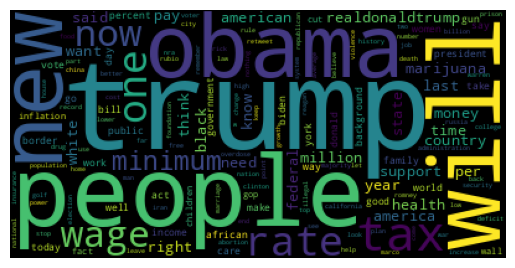

In [ ]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

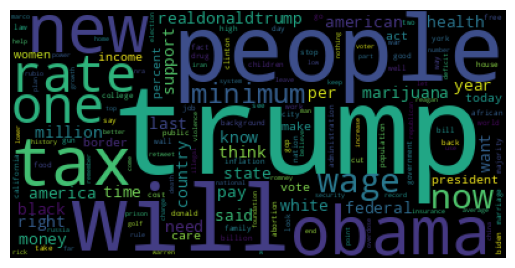

In [ ]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==1],'text')
nreal = ' '.join(nreal.index)
nreal
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


# Classification with TF-IDF and SVM
This is a NLP model

In [ ]:
text = tweet['text']
y = tweet['target']

In [ ]:
tfidf =TfidfVectorizer()
x = tfidf.fit_transform(text)
x.shape

(134198, 169576)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def calculate_rates(y_test, y_scores, thresholds):
    fpr_values = []
    tpr_values = []

    for threshold in thresholds:
        y_pred_threshold = (y_scores >= threshold).astype(int)
        TP = np.sum((y_test == 1) & (y_pred_threshold == 1))
        FP = np.sum((y_test == 0) & (y_pred_threshold == 1))
        TN = np.sum((y_test == 0) & (y_pred_threshold == 0))
        FN = np.sum((y_test == 1) & (y_pred_threshold == 0))

        TPR = TP / (TP + FN)
        FPR = FP / (TN + FP)
        fpr_values.append(FPR)
        tpr_values.append(TPR)

    return fpr_values, tpr_values

def true_rates(clf, X_train, X_test, y_train, y_test):
    #clf.fit(X_train, y_train)
    #y_pred = clf.predict(X_test)
    #accuracy = clf.score(X_test, y_test)
    #print(f"Accuracy: {accuracy:.4f}")
    #print("Classification report:")
    #report = classification_report(y_test, y_pred)
    #print(report)

    # Calculate TP and FP
    #TP = np.sum((y_test == 1) & (y_pred == 1))
    #FP = np.sum((y_test == 0) & (y_pred == 1))
    y_scores = clf.decision_function(X_test)
    # Calculate ROC curve rates
    thresholds = np.linspace(min(y_scores), max(y_scores), 100)  # Example thresholds
    fpr_values, tpr_values = calculate_rates(y_test, y_scores, thresholds)

    return fpr_values, tpr_values

def true_rates_dtc(clf, X_train, X_test, y_train, y_test):
   y_scores = clf.predict_proba(X_test)
   print(y_scores)
   # Calculate ROC curve rates
   thresholds = np.linspace(min(y_scores), max(y_scores), 100)  # Example thresholds
   fpr_values, tpr_values = calculate_rates(y_test, y_scores, thresholds)
   return fpr_values, tpr_values

In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")
print("Classification report:")
report = classification_report(y_test, y_pred)
print(report)
fpr_tf_idf, tpr_tf_idf = true_rates(clf, X_train, X_test, y_train, y_test)

Accuracy: 0.9835
Classification report:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98     13054
        True       0.98      0.98      0.98     13786

    accuracy                           0.98     26840
   macro avg       0.98      0.98      0.98     26840
weighted avg       0.98      0.98      0.98     26840



# Classification with Word2Vec and SVM

## Method 1 of Word2Vec model


In [ ]:
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
def get_tweet_vector(tweet, model):
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

y = tweet['target']
tokenized_tweets = [word_tokenize(tweet.lower()) for tweet in tweet['text']]

X_train, X_test, y_train, y_test = train_test_split(tokenized_tweets, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def get_tweet_vector(tweet, model):
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [ ]:
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
y = tweet['target']
tokenized_tweets = [word_tokenize(tweet.lower()) for tweet in tweet['text']]

X_train, X_test, y_train, y_test = train_test_split(tokenized_tweets, y, test_size=0.2, random_state=42, stratify=y)

model = Word2Vec(X_train, vector_size=100, window=5, min_count=1, sg=1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
X_train_vec = [get_tweet_vector(tweet, model) for tweet in X_train]
X_test_vec = [get_tweet_vector(tweet, model) for tweet in X_test]

clf = LogisticRegression(max_iter=500)
clf.fit(X_train_vec, y_train)
fpr_w2v, tpr_w2v = true_rates(clf, X_train_vec, X_test_vec, y_train, y_test)
y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.86      0.86     13054
        True       0.87      0.87      0.87     13786

    accuracy                           0.87     26840
   macro avg       0.87      0.87      0.87     26840
weighted avg       0.87      0.87      0.87     26840



## Method 2 of Word2Vec model

In [ ]:
import spacy
import en_core_web_lg

In [ ]:
nlp = en_core_web_lg.load()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [ ]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [ ]:
tweet.head()

,id,author,statement,target,BinaryNumTarget,manual_keywords,text,5_label_majority_answer,3_label_majority_answer,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",potus biden blunders 6 month updateinflation d...,Mostly Agree,Agree,247,40,6.175000,6,0,1,13,5,"[-0.82935965, -0.2925869, -2.5063546, 0.769187..."
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",s0sickrick stairmaster 6d6f636869 not as many ...,NO MAJORITY,Agree,257,44,5.840909,20,0,3,9,0,"[-2.802699, 0.84415936, -1.4352779, 0.81710905..."
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",the supreme court is siding with super rich pr...,Agree,Agree,187,35,5.342857,14,0,0,1,5,"[-2.1645498, 0.70877975, -3.191392, 0.68933946..."
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",potus biden blundersbroken campaign promises i...,Mostly Agree,Agree,249,37,6.729730,4,0,1,13,3,"[-0.90175855, -0.034947377, -2.0676923, 1.2282..."
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",ohcomfy i agree the confluence of events right...,Agree,Agree,205,35,5.857143,10,0,1,7,2,"[-2.5191689, -0.56711406, -1.7233003, 0.411921..."


In [ ]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)
X.shape

(134198, 1)

In [ ]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)
X.shape

(134198, 300)

In [ ]:
y = tweet['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf = LinearSVC()
run_SVM(clf ,X_train, X_test, y_train, y_test)


Classification report
              precision    recall  f1-score   support

       False       0.66      0.92      0.77     13054
        True       0.88      0.55      0.68     13786

    accuracy                           0.73     26840
   macro avg       0.77      0.74      0.73     26840
weighted avg       0.77      0.73      0.72     26840



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Word Embeddings and Classification with Deep Learning

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
import numpy as np


text = tweet['text']
y = tweet['target']
token = Tokenizer()
token.fit_on_texts(text)
vocab_size = len(token.word_index) + 1
encoded_text = token.texts_to_sequences(text)
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
vec_size = 100

# Define the model architecture
def create_model():
    model = Sequential()
    model.add(Embedding(vocab_size, vec_size, input_length=max_length))
    #model.add(Conv1D(32, 2, activation='relu'))          #0.5716
    #model.add(MaxPooling1D(2))                                #0.5716
    #model.add(Dropout(0.5))                                       #0.5507
    #model.add(Dense(32, activation='relu'))                #0.5505
    #model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu'))
    model.add(GlobalMaxPooling1D())                       #0.9918
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Evaluate the original model.        0.95,  0.95,  0.97, 0.9804

In [ ]:
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))
original_loss, original_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Original Accuracy: {original_accuracy}")

Epoch 1/3
3355/3355 [==============================] - 54s 16ms/step - loss: 0.1382 - accuracy: 0.9590 - val_loss: 0.0397 - val_accuracy: 0.9871
Epoch 2/3
3355/3355 [==============================] - 32s 10ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.0271 - val_accuracy: 0.9911
Epoch 3/3
3355/3355 [==============================] - 30s 9ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0237 - val_accuracy: 0.9920
Original Accuracy: 0.9919523000717163


In [ ]:
print(original_loss)

0.0630846843123436


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [ ]:
text = tweet['text']

In [ ]:
token = Tokenizer()
token.fit_on_texts(text)

In [ ]:
vocab_size = len(token.word_index) + 1
vocab_size

196034

In [ ]:
encoded_text = token.texts_to_sequences(text)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding = 'post')
print(X)

[[   261     36  14417 ...      0      0      0]
 [ 57508  57509  57510 ...      0      0      0]
 [     1    512    268 ...      0      0      0]
 ...
 [196033     98    287 ...      0      0      0]
 [   388    641     13 ...      0      0      0]
 [  7239    290   6339 ...      0      0      0]]


In [ ]:
X.shape

(134198, 120)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#clf = LinearSVC()
#run_SVM(clf ,X_train, X_test, y_train, y_test)

In [ ]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          19603400  
                                                                 
 conv1d (Conv1D)             (None, 119, 32)           6432      
                                                                 
 max_pooling1d (MaxPooling1  (None, 59, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 59, 32)            0         
                                                                 
 dense (Dense)               (None, 59, 32)            1056      
                                                                 
 dropout_1 (Dropout)         (None, 59, 32)            0         
                                                        

In [ ]:
model.compile(optimizer= 'adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

3355/3355 [==============================] - 126s 35ms/step - loss: 0.1655 - accuracy: 0.9306 - val_loss: 0.1358 - val_accuracy: 0.9722
[0.9721683859825134] [0.16550005972385406] [0.1358189433813095]
CPU times: user 1min 19s, sys: 3.12 s, total: 1min 22s
Wall time: 2min 5s


In [ ]:
model.compile(optimizer= 'adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
3355/3355 [==============================] - 74s 21ms/step - loss: 0.0644 - accuracy: 0.9791 - val_loss: 0.1477 - val_accuracy: 0.9778
Epoch 2/5
3355/3355 [==============================] - 38s 11ms/step - loss: 0.0468 - accuracy: 0.9851 - val_loss: 0.1779 - val_accuracy: 0.9787
Epoch 3/5
3355/3355 [==============================] - 37s 11ms/step - loss: 0.0371 - accuracy: 0.9878 - val_loss: 0.2178 - val_accuracy: 0.9558
Epoch 4/5
3355/3355 [==============================] - 36s 11ms/step - loss: 0.0292 - accuracy: 0.9904 - val_loss: 0.2029 - val_accuracy: 0.9637
Epoch 5/5
3355/3355 [==============================] - 36s 11ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.2233 - val_accuracy: 0.9316
[0.9778316020965576, 0.978725790977478, 0.9557749629020691, 0.9636736512184143, 0.9315946102142334] [0.06438387185335159, 0.046810392290353775, 0.03713236376643181, 0.02920101210474968, 0.024662701413035393] [0.14766456186771393, 0.17789781093597412, 0.21784988045692444, 0.2

In [ ]:
model.compile(optimizer= 'adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test))
history_dict = history.history

Epoch 1/6
3355/3355 [==============================] - 86s 23ms/step - loss: 0.1647 - accuracy: 0.9318 - val_loss: 0.1386 - val_accuracy: 0.9714
Epoch 2/6
3355/3355 [==============================] - 38s 11ms/step - loss: 0.0645 - accuracy: 0.9792 - val_loss: 0.1654 - val_accuracy: 0.9758
Epoch 3/6
3355/3355 [==============================] - 38s 11ms/step - loss: 0.0471 - accuracy: 0.9852 - val_loss: 0.1774 - val_accuracy: 0.9725
Epoch 4/6
3355/3355 [==============================] - 47s 14ms/step - loss: 0.0354 - accuracy: 0.9886 - val_loss: 0.1777 - val_accuracy: 0.9736
Epoch 5/6
3355/3355 [==============================] - 38s 11ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.1688 - val_accuracy: 0.9732
Epoch 6/6
3355/3355 [==============================] - 37s 11ms/step - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.1396 - val_accuracy: 0.9713
CPU times: user 4min 25s, sys: 13.4 s, total: 4min 39s
Wall time: 4min 43s


In [ ]:
from sklearn.metrics import roc_curve, auc
accuracy = history.history['accuracy'][len(history.history['accuracy'])-1]
print(f"Accuracy: {accuracy:.4f}")
print("Classification report:")
true_classes = y_test
predictions = model.predict(X_test)
predicted_classes = np.round(predictions).flatten()
class_labels = ['False', 'True']
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
fpr_we, tpr_we, thresholds = roc_curve(true_classes, predictions)
roc_auc_we = auc(fpr_we, tpr_we)

Accuracy: 0.9970
Classification report:
839/839 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     13054
        True       0.99      0.99      0.99     13786

    accuracy                           0.99     26840
   macro avg       0.99      0.99      0.99     26840
weighted avg       0.99      0.99      0.99     26840



In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [ ]:
x = 'president biden announces a new infrastructure plan to rebuild roads and bridges across the united states'
vec = get_encoded(x)

In [ ]:
vec

array([[  90,   36, 5416,    5,   74, 1379,  338,    2, 5555, 2312,    4,
        3585,  713,    1,  203,   79,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [ ]:
n = np.argmax(model.predict(vec), axis = -1)
print(f'Given input string: \"{x}\"')
print("The lable of the given input is : " ,'True' if n[0]==1 else 'False')

1/1 [==============================] - 0s 251ms/step
Given input string: "president biden announces a new infrastructure plan to rebuild roads and bridges across the united states"
The lable of the given input is :  False


# BERT Model Building and Training

In [ ]:
from ktrain import text
import ktrain

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns = 'target', maxlen=40, preprocess_mode='bert')

['not_target', 'target']
        not_target  target
126528         1.0     0.0
112802         1.0     0.0
36634          0.0     1.0
87006          1.0     0.0
89643          1.0     0.0
['not_target', 'target']
       not_target  target
64105         0.0     1.0
28997         0.0     1.0
89150         1.0     0.0
30993         0.0     1.0
76362         1.0     0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [ ]:
learner = ktrain.get_learner(model=model, train_data = (X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr= 1e-7, epochs=1)



begin training using onecycle policy with max lr of 1e-07...
 788/1888 [===========>..................] - ETA: 9:41 - loss: 0.4487 - accuracy: 0.7975

In [ ]:
#learner.fit_onecycle(lr= 2e-5, epochs=3)

In [ ]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr= 2e-7, epochs=3)



begin training using onecycle policy with max lr of 2e-07...
Epoch 1/3
1888/1888 [==============================] - 1071s 555ms/step - loss: 0.6747 - accuracy: 0.5749 - val_loss: 0.6210 - val_accuracy: 0.6634
Epoch 2/3
1888/1888 [==============================] - 1046s 554ms/step - loss: 0.5494 - accuracy: 0.7299 - val_loss: 0.4790 - val_accuracy: 0.7731
Epoch 3/3
1888/1888 [==============================] - 1046s 554ms/step - loss: 0.4631 - accuracy: 0.7873 - val_loss: 0.4358 - val_accuracy: 0.8010


simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/1024
1888/1888 [==============================] - 663s 351ms/step - loss: 0.5490 - accuracy: 0.8141


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(




done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


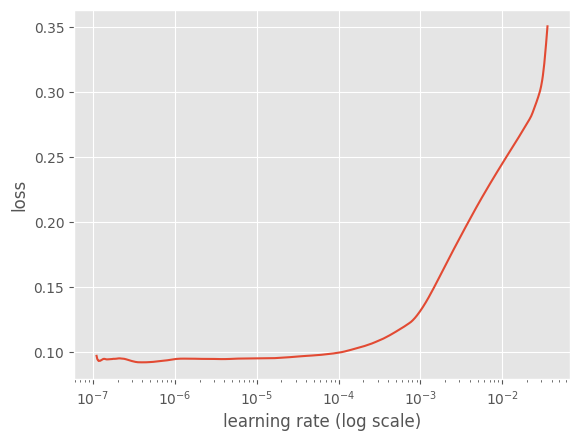

In [ ]:
# to find best learning rate?
learner.lr_find()
learner.lr_plot()

In [ ]:
predictor= ktrain.get_predictor(learner.model, preproc)

In [ ]:
from sklearn.metrics import roc_curve, auc
true_classes = y_test
predictions = predictor.predict(X_test)
predicted_classes = np.round(predictions).flatten()
class_labels = ['True', 'False']
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification report: ")
print(report)
fpr_bert, tpr_bert, thresholds = roc_curve(true_classes, predictions)
roc_auc_bert = auc(fpr_bert, tpr_bert)

ValueError: invalid text format: texts should be list of strings or list of sentence pairs in form of tuples (str, str)

In [ ]:
data = ['i met you today by accident', 'i got today car accident, i am injured', 'Caitlin Clark, the only current college player, has been invited to the USA Basketball training camp, which will take place in Cleveland during the women’s Final Four']

In [ ]:
predictor.predict(data, return_proba=True)

In [ ]:
predictor.predict(data[2])

In [ ]:
classes = predictor.get_classes()

In [ ]:
data

In [ ]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

In [ ]:
y_train

# Supervised Models


In [ ]:
x = tweet['text']
y = tweet['target']


vectorization = TfidfVectorizer()
X = vectorization.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)
pred_lr = lr.predict(x_test)
accuracy = lr.score(x_test, y_test)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, pred_lr))
fpr_lr, tpr_lr = true_rates(lr, x_train, x_test, y_train, y_test)

Accuracy: 0.9757078986587183
              precision    recall  f1-score   support

       False       0.98      0.97      0.97     13076
        True       0.97      0.98      0.98     13764

    accuracy                           0.98     26840
   macro avg       0.98      0.98      0.98     26840
weighted avg       0.98      0.98      0.98     26840



## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
pred_dtc = dtc.predict(x_test)
accuracy = dtc.score(x_test, y_test)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, pred_dtc))


Accuracy: 0.9687406855439642
              precision    recall  f1-score   support

       False       0.97      0.96      0.97     13076
        True       0.97      0.97      0.97     13764

    accuracy                           0.97     26840
   macro avg       0.97      0.97      0.97     26840
weighted avg       0.97      0.97      0.97     26840



## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
pred_rfc = rfc.predict(x_test)
accuracy = rfc.score(x_test, y_test)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, pred_rfc))
fpr_rfc, tpr_rfc = true_rates(rfc, X_train, X_test, y_train, y_test)

Accuracy: 0.9713859910581222
              precision    recall  f1-score   support

       False       0.98      0.96      0.97     13076
        True       0.97      0.98      0.97     13764

    accuracy                           0.97     26840
   macro avg       0.97      0.97      0.97     26840
weighted avg       0.97      0.97      0.97     26840



## Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = RandomForestClassifier()
gbc.fit(x_train, y_train)
pred_gbc = gbc.predict(x_test)
accuracy = gbc.score(x_test, y_test)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, pred_gbc))
fpr_gbc, tpr_gbc = true_rates(gbc, X_train, X_test, y_train, y_test)

Accuracy: 0.9715350223546945
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     13076
        True       0.97      0.98      0.97     13764

    accuracy                           0.97     26840
   macro avg       0.97      0.97      0.97     26840
weighted avg       0.97      0.97      0.97     26840



## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

mnb = MultinomialNB()
mnb.fit(x_train, y_train)
pred_mnb = mnb.predict(x_test)
accuracy = mnb.score(x_test, y_test)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, pred_mnb))
fpr_mnb, tpr_mnb = true_rates(mnb, X_train, X_test, y_train, y_test)

Accuracy: 0.9445976154992548
              precision    recall  f1-score   support

       False       0.95      0.94      0.94     13076
        True       0.94      0.95      0.95     13764

    accuracy                           0.94     26840
   macro avg       0.94      0.94      0.94     26840
weighted avg       0.94      0.94      0.94     26840



## Stochastic Gradient Decent

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
pred_sgd = sgd.predict(x_test)
accuracy = sgd.score(x_test, y_test)
print("Accuracy: ", accuracy)
print(classification_report(y_test, pred_sgd))
fpr_sgd, tpr_sgd = true_rates(sgd, X_train, X_test, y_train, y_test)

Accuracy:  0.9692250372578242
              precision    recall  f1-score   support

       False       0.97      0.96      0.97     13076
        True       0.97      0.97      0.97     13764

    accuracy                           0.97     26840
   macro avg       0.97      0.97      0.97     26840
weighted avg       0.97      0.97      0.97     26840



## K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)
accuracy = knn.score(x_test, y_test)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, pred_knn))
fpr_knn, tpr_knn = true_rates(knn, X_train, X_test, y_train, y_test)

Accuracy: 0.9795454545454545
              precision    recall  f1-score   support

       False       0.98      0.98      0.98     13076
        True       0.98      0.98      0.98     13764

    accuracy                           0.98     26840
   macro avg       0.98      0.98      0.98     26840
weighted avg       0.98      0.98      0.98     26840



# Graphs

## Validation and training curves

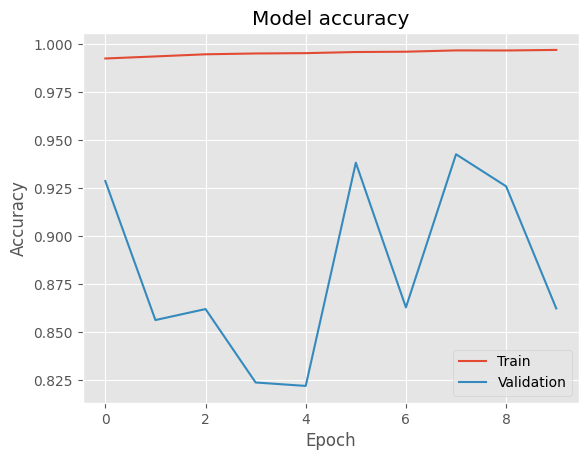

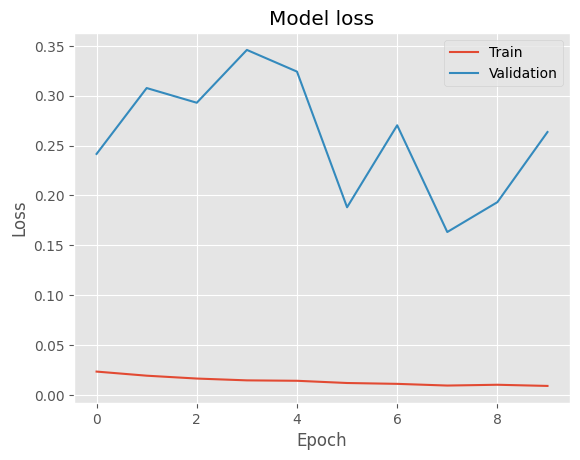

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


## ROC curves

###  Logistic Regression

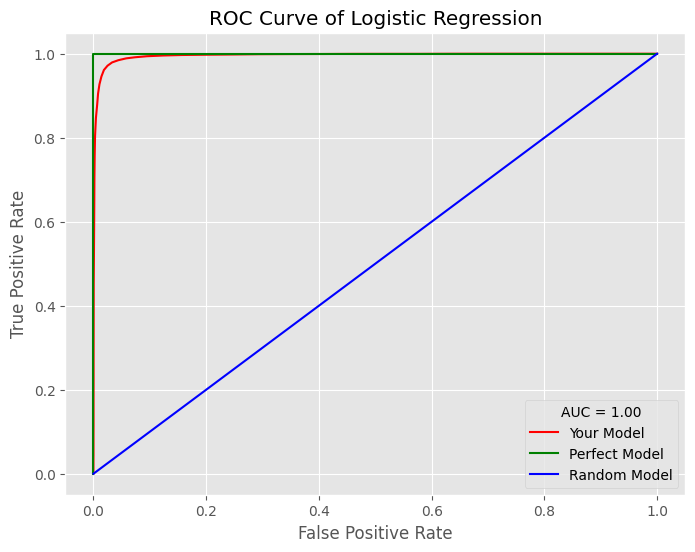

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Your Model', color='red')

perfect_model_fp = [0, 0, 1]
perfect_model_tp = [0, 1, 1]
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')

random_model_fp = [0, 1]
random_model_tp = [0, 1]
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')

plt.grid(True)
from sklearn.metrics import auc
roc_auc = auc(fpr_lr, tpr_lr)
plt.legend(loc='lower right', title=f'AUC = {roc_auc:.2f}')

plt.show()



### Decision tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(x_train, y_train)


y_scores = clf.predict_proba(x_test)


positive_class_index = 1
fpr, tpr, _ = roc_curve(y_test, y_scores[:, positive_class_index])
roc_auc = auc(fpr, tpr)

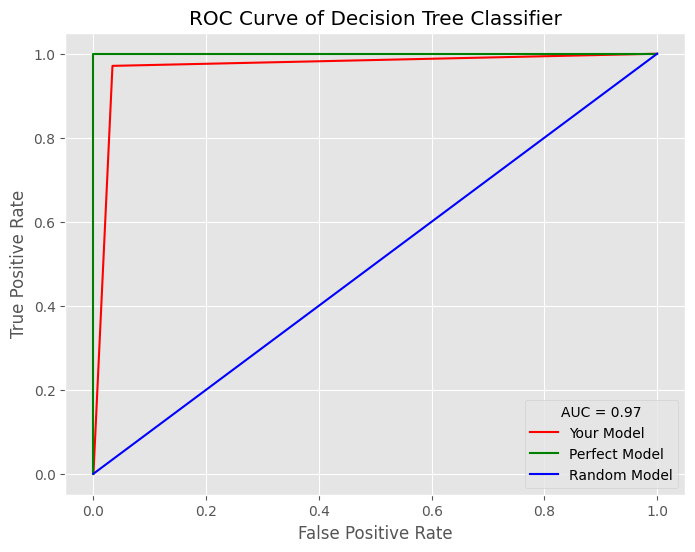

In [ ]:

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Your Model', color='red')
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree Classifier')

plt.grid(True)
plt.legend(loc='lower right', title=f'AUC = {roc_auc:.2f}')
plt.show()

### Random. Forest

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split


rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(x_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=42)

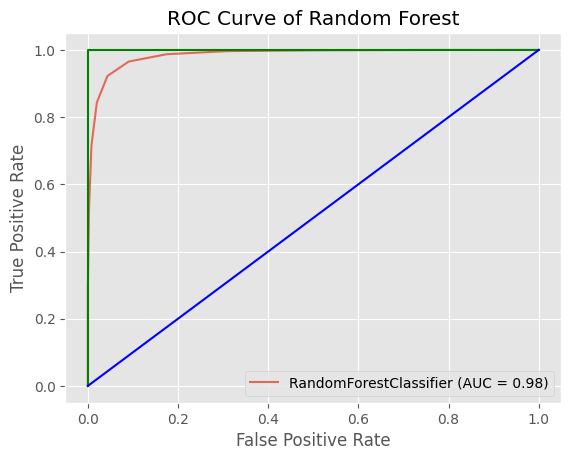

In [ ]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, x_test, y_test, ax=ax, alpha=0.8)
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.show()

### Gradient Boosting Classifier

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split

clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

GradientBoostingClassifier()

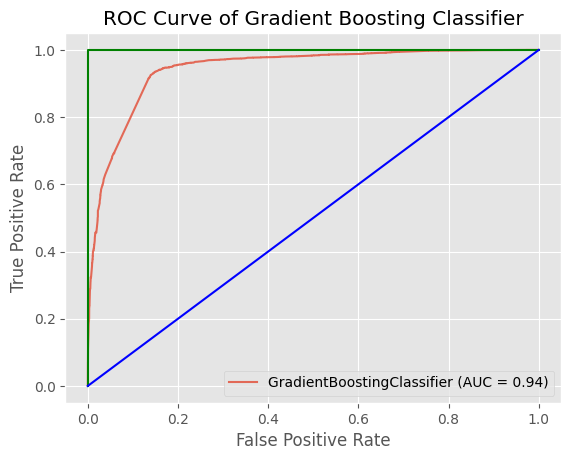

In [ ]:
ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(clf, x_test, y_test, ax=ax, alpha=0.8)
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Gradient Boosting Classifier')
plt.show()

### Multinomial Naive Bayes

In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nb = MultinomialNB(fit_prior=False)
nb.fit(X, y)

y_prob = nb.predict_proba(X)[:, 1]

fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

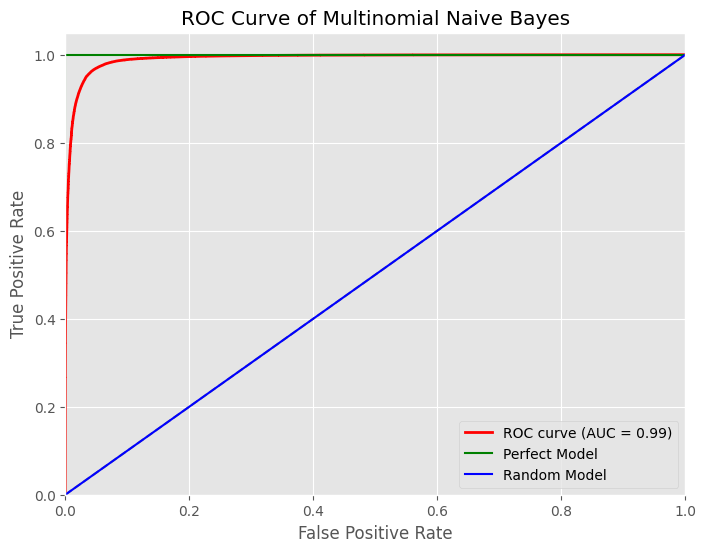

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Multinomial Naive Bayes')
plt.legend(loc='lower right')
plt.show()

### Stochastic Gradient Decent

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc

sgd_classifier = SGDClassifier(loss='log', random_state=42)
sgd_classifier.fit(x_train, y_train)

y_pred_prob = sgd_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

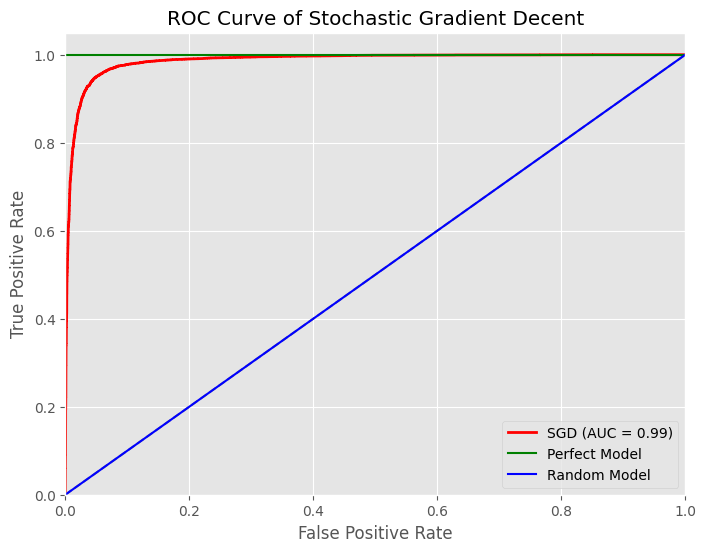

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='r', lw=2, label='SGD (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Stochastic Gradient Decent')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### K Nearest Neighbors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

y_scores = knn.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

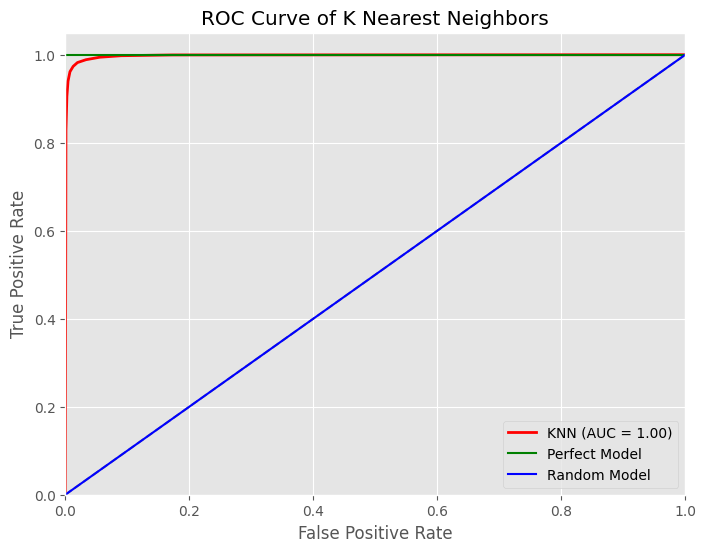

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='r', lw=2, label='KNN (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of K Nearest Neighbors')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### ROC TF-IDF

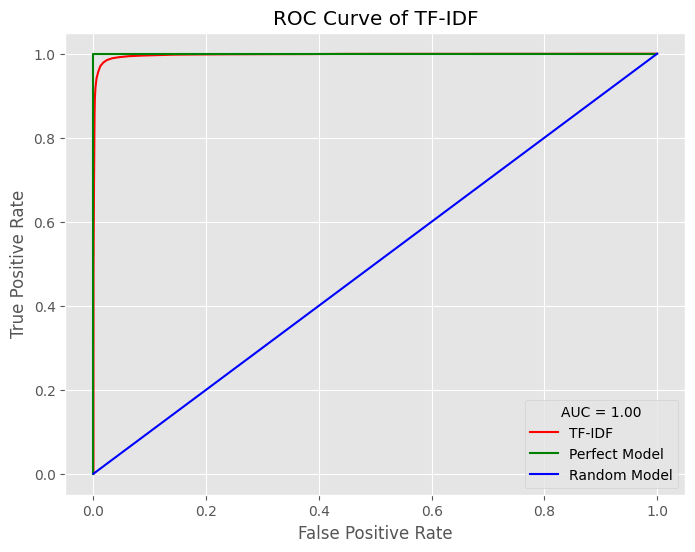

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your existing code for plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tf_idf, tpr_tf_idf, label='TF-IDF', color='red')

perfect_model_fp = [0, 0, 1]
perfect_model_tp = [0, 1, 1]
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')

random_model_fp = [0, 1]
random_model_tp = [0, 1]
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of TF-IDF')

plt.grid(True)

from sklearn.metrics import auc
roc_auc = auc(fpr_tf_idf, tpr_tf_idf)
plt.legend(loc='lower right', title=f'AUC = {roc_auc:.2f}')

plt.show()


### Word2Vec

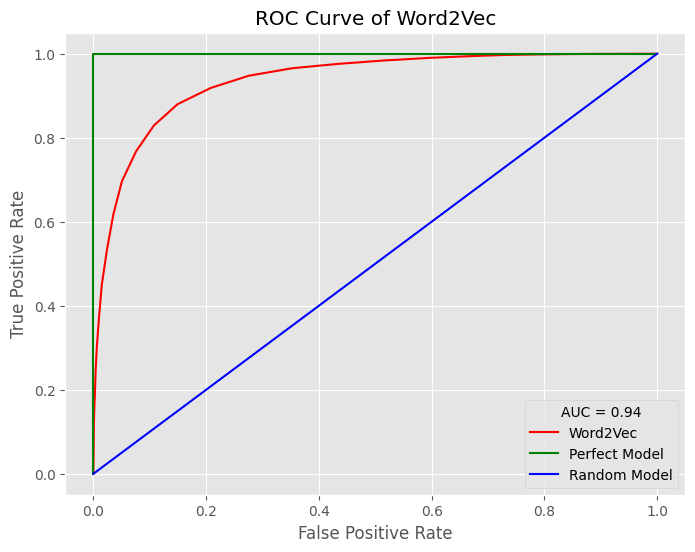

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
plt.plot(fpr_w2v, tpr_w2v, label='Word2Vec', color='red')

perfect_model_fp = [0, 0, 1]
perfect_model_tp = [0, 1, 1]
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')

random_model_fp = [0, 1]
random_model_tp = [0, 1]
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Word2Vec')

plt.grid(True)
from sklearn.metrics import auc
roc_auc = auc(fpr_w2v, tpr_w2v)
plt.legend(loc='lower right', title=f'AUC = {roc_auc:.2f}')

plt.show()


### BERT

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
plt.plot(fpr_bert, tpr_bert, label='BERT', color='red')

perfect_model_fp = [0, 0, 1]
perfect_model_tp = [0, 1, 1]
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')

random_model_fp = [0, 1]
random_model_tp = [0, 1]
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of BERT')

plt.grid(True)
plt.legend()
plt.show()


### Word Embedding

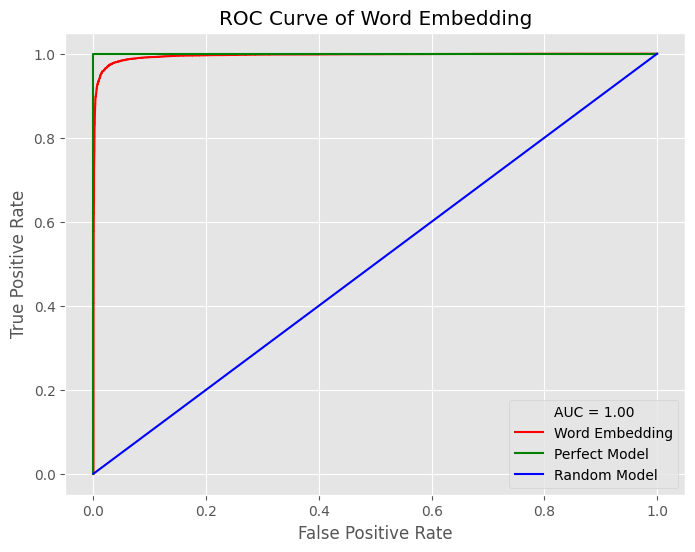

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
plt.plot(fpr_we, tpr_we, label='Word Embedding', color='red')

perfect_model_fp = [0, 0, 1]
perfect_model_tp = [0, 1, 1]
plt.plot(perfect_model_fp, perfect_model_tp, label='Perfect Model', color='green')

random_model_fp = [0, 1]
random_model_tp = [0, 1]
plt.plot(random_model_fp, random_model_tp, label='Random Model', color='blue')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Word Embedding')

plt.grid(True)
from sklearn.metrics import auc
roc_auc = auc(fpr_we, tpr_we)
plt.legend(loc='lower right', title=f'AUC = {roc_auc:.2f}')

plt.show()


# Lable Classifications


In [ ]:
unique_labels = tweet['5_label_majority_answer'].unique()
num_labels = len(unique_labels)
label_map = {label: i for i, label in enumerate(unique_labels)}

print("Unique labels:")
for label in unique_labels:
    print(label)

print("\nLabel mapping:")
for label, num in label_map.items():
    print(f"{label}: {num}")

tweet['5_label_majority_answer_numerical'] = tweet['5_label_majority_answer'].map(label_map)


Unique labels:
Mostly Agree
NO MAJORITY
Agree
Mostly Disagree
Disagree

Label mapping:
Mostly Agree: 0
NO MAJORITY: 1
Agree: 2
Mostly Disagree: 3
Disagree: 4


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

text = tweet['text']
y = tweet['3_label_majority_answer']
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(text)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Accuracy: 0.9572280178837556
Classification report
              precision    recall  f1-score   support

       Agree       0.96      1.00      0.98     25695
    Disagree       0.00      0.00      0.00      1145

    accuracy                           0.96     26840
   macro avg       0.48      0.50      0.49     26840
weighted avg       0.92      0.96      0.94     26840



In [ ]:
def get_label_vector(label, model):
    vectors = [model.wv[word] for word in label.split() if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

y = tweet['3_label_majority_answer']
tokenized_labels = [label.lower() for label in tweet['3_label_majority_answer']]

X_train, X_test, y_train, y_test = train_test_split(tokenized_labels, y, test_size=0.2, random_state=42, stratify=y)

model = Word2Vec(X_train, vector_size=100, window=5, min_count=1, sg=1)
X_train_vec = [get_label_vector(label, model) for label in X_train]
X_test_vec = [get_label_vector(label, model) for label in X_test]

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Agree       0.96      1.00      0.98     25695
    Disagree       0.00      0.00      0.00      1145

    accuracy                           0.96     26840
   macro avg       0.48      0.50      0.49     26840
weighted avg       0.92      0.96      0.94     26840



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
